In [3]:
import os
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data preprocessing

In [6]:
path = "dataset_primary/dataset_primary/data_05S01/"
no_attack_dir = os.listdir(path + "0/")
attack_dir = os.listdir(path + "1/")

In [7]:
# Load the images and labels into memory
images = np.zeros((len(no_attack_dir) + len(attack_dir), 112, 112, 3), dtype=np.float32)
labels = np.zeros(len(no_attack_dir) + len(attack_dir), dtype=np.int32)

# load the images and labels into memory
for i, filename in enumerate(no_attack_dir):
    img = Image.open(path + "0/" + filename).convert("RGB")
    img = img.resize((112, 112), Image.BILINEAR)
    img = np.asarray(img, dtype=np.float32)
    images[i] = img
for i, filename in enumerate(attack_dir):
    img = Image.open(path + "1/" + filename).convert("RGB")
    img = img.resize((112, 112), Image.BILINEAR)
    img = np.asarray(img, dtype=np.float32)
    images[i + len(no_attack_dir)] = img
    labels[i + len(no_attack_dir)] = 1

In [8]:
labels = tf.keras.utils.to_categorical(labels, 2)
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [9]:
# Shuffle the data and split into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
del images, labels

# Models

In [10]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation="relu", input_shape=(112, 112, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 16)       0

2023-04-09 21:13:02.778865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-09 21:13:02.779184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-09 21:13:02.779327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [18]:
model.save_weights('pretraining/weights')

In [11]:
histories = []
lrs = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.0025, 0.001, 0.00075, 0.0005, 0.00025, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001]

In [12]:
for lr in lrs:
    model.load_weights('pretraining/weights')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    
    history = model.fit(
        X_train,
        y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_test, y_test),
    )
    
    histories.append(history)
    print(lr, "Done")

Epoch 1/15


2023-04-09 21:13:32.120101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-09 21:13:34.509981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-09 21:13:34.519951: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4792520350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-09 21:13:34.519983: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-04-09 21:13:34.525765: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-09 21:13:34.661243: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

562/562 [==============================] - 11s 7ms/step - loss: 50087080.0000 - accuracy: 0.5776 - val_loss: 0.6674 - val_accuracy: 0.6159
Epoch 2/15
562/562 [==============================] - 3s 5ms/step - loss: 0.7001 - accuracy: 0.5719 - val_loss: 0.6865 - val_accuracy: 0.6159
Epoch 3/15
562/562 [==============================] - 3s 5ms/step - loss: 0.7031 - accuracy: 0.5709 - val_loss: 0.7249 - val_accuracy: 0.3841
Epoch 4/15
562/562 [==============================] - 3s 5ms/step - loss: 0.6981 - accuracy: 0.5694 - val_loss: 0.6672 - val_accuracy: 0.6159
Epoch 5/15
562/562 [==============================] - 3s 5ms/step - loss: 0.6907 - accuracy: 0.5830 - val_loss: 0.6661 - val_accuracy: 0.6159
Epoch 6/15
562/562 [==============================] - 3s 5ms/step - loss: 0.6977 - accuracy: 0.5748 - val_loss: 0.6740 - val_accuracy: 0.6159
Epoch 7/15
562/562 [==============================] - 3s 5ms/step - loss: 0.6848 - accuracy: 0.5862 - val_loss: 0.6787 - val_accuracy: 0.6159
Epoch 8/1

562/562 [==============================] - 3s 5ms/step - loss: 0.2844 - accuracy: 0.8537 - val_loss: 0.3008 - val_accuracy: 0.8383
Epoch 11/15
562/562 [==============================] - 3s 5ms/step - loss: 0.2817 - accuracy: 0.8519 - val_loss: 0.3098 - val_accuracy: 0.8339
Epoch 12/15
562/562 [==============================] - 3s 5ms/step - loss: 0.2746 - accuracy: 0.8554 - val_loss: 0.3101 - val_accuracy: 0.8390
Epoch 13/15
562/562 [==============================] - 3s 5ms/step - loss: 0.2745 - accuracy: 0.8568 - val_loss: 0.3260 - val_accuracy: 0.8381
Epoch 14/15
562/562 [==============================] - 3s 5ms/step - loss: 0.2763 - accuracy: 0.8540 - val_loss: 0.2978 - val_accuracy: 0.8390
Epoch 15/15
562/562 [==============================] - 3s 5ms/step - loss: 0.2690 - accuracy: 0.8592 - val_loss: 0.2958 - val_accuracy: 0.8403
0.001 Done
Epoch 1/15
562/562 [==============================] - 5s 7ms/step - loss: 1.1620 - accuracy: 0.7570 - val_loss: 0.3538 - val_accuracy: 0.8274
E

562/562 [==============================] - 3s 5ms/step - loss: 11.1921 - accuracy: 0.6007 - val_loss: 4.2672 - val_accuracy: 0.7023
Epoch 5/15
562/562 [==============================] - 3s 5ms/step - loss: 8.1462 - accuracy: 0.6234 - val_loss: 3.2844 - val_accuracy: 0.7168
Epoch 6/15
562/562 [==============================] - 3s 5ms/step - loss: 5.9031 - accuracy: 0.6378 - val_loss: 2.5410 - val_accuracy: 0.7257
Epoch 7/15
562/562 [==============================] - 3s 5ms/step - loss: 4.2520 - accuracy: 0.6475 - val_loss: 1.9353 - val_accuracy: 0.7252
Epoch 8/15
562/562 [==============================] - 3s 5ms/step - loss: 2.9991 - accuracy: 0.6585 - val_loss: 1.4830 - val_accuracy: 0.7206
Epoch 9/15
562/562 [==============================] - 3s 5ms/step - loss: 2.2668 - accuracy: 0.6519 - val_loss: 1.1528 - val_accuracy: 0.7079
Epoch 10/15
562/562 [==============================] - 3s 6ms/step - loss: 1.5866 - accuracy: 0.6463 - val_loss: 0.9308 - val_accuracy: 0.6983
Epoch 11/15
562

# Results

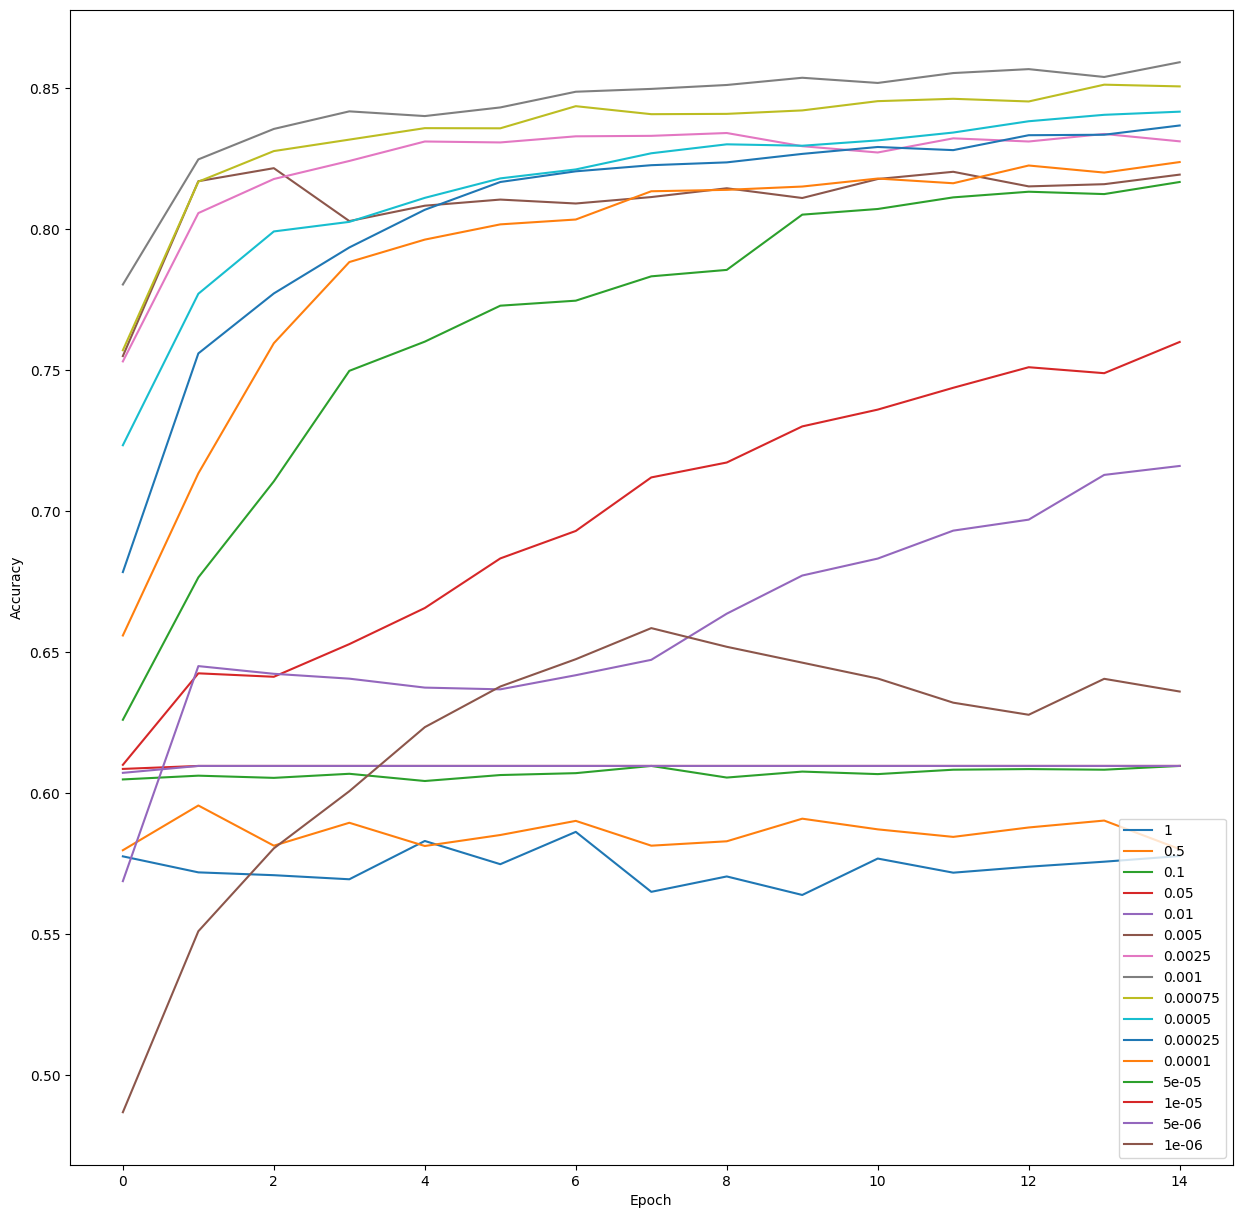

In [15]:
plt.figure(figsize=((15, 15)))

for lr, history in zip(lrs, histories):    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))
    plt.plot(epochs, acc, label=lr)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

    

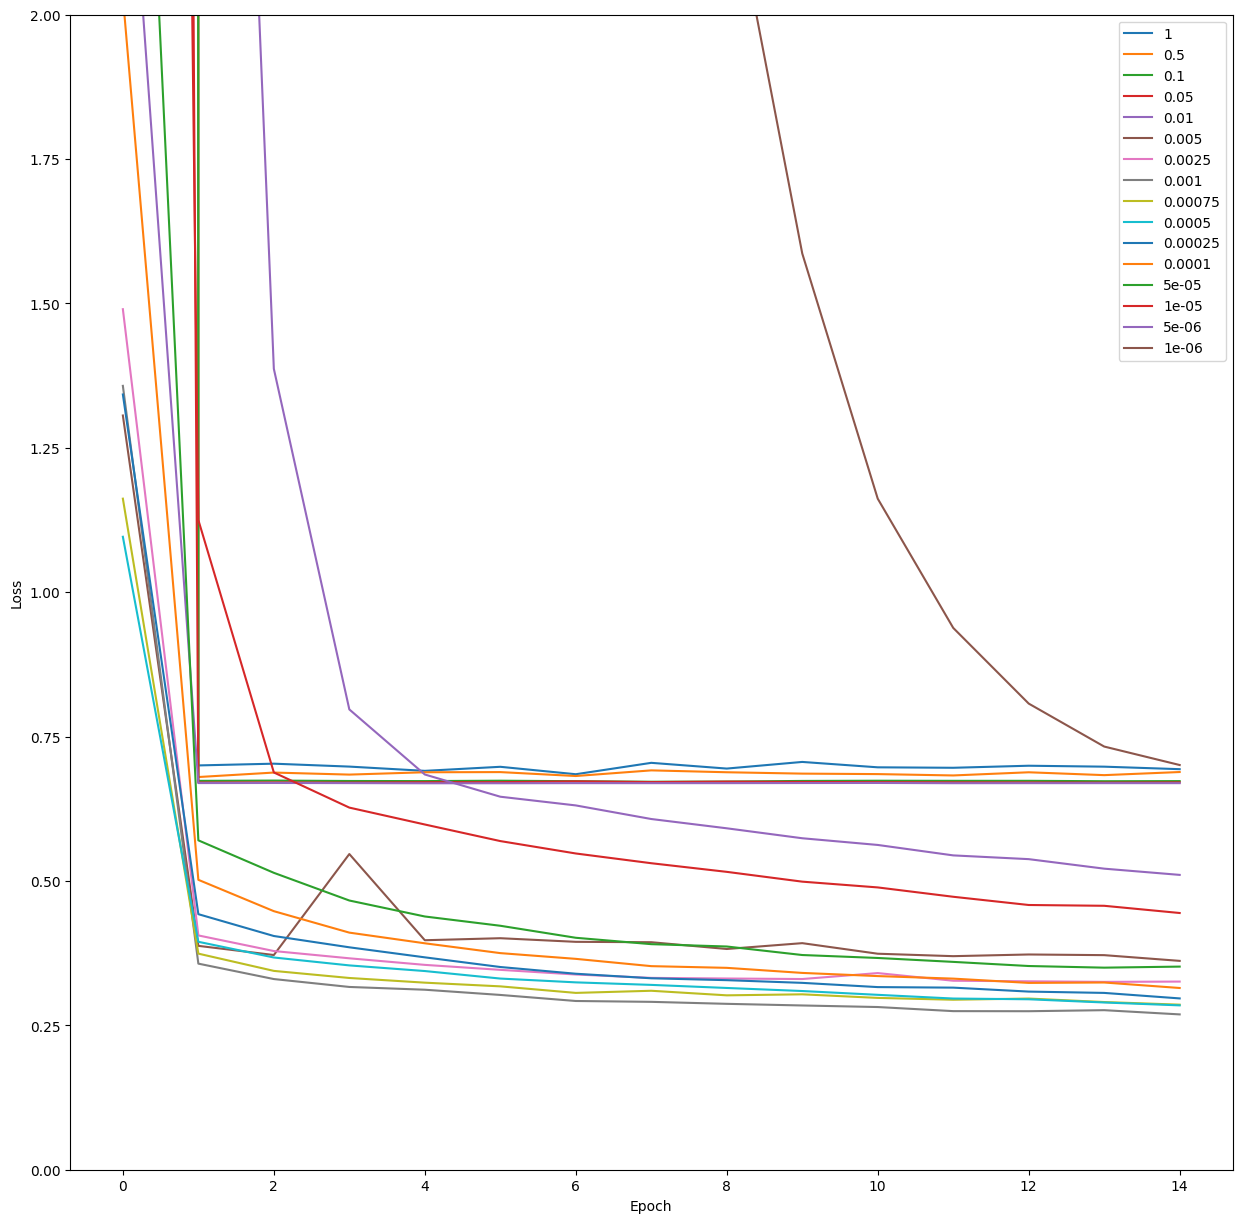

In [19]:
plt.figure(figsize=((15, 15)))

for lr, history in zip(lrs, histories):    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))
    plt.plot(epochs, loss, label=lr)

plt.xlabel("Epoch")
plt.ylim((0, 2))
plt.ylabel("Loss")
plt.legend()

    

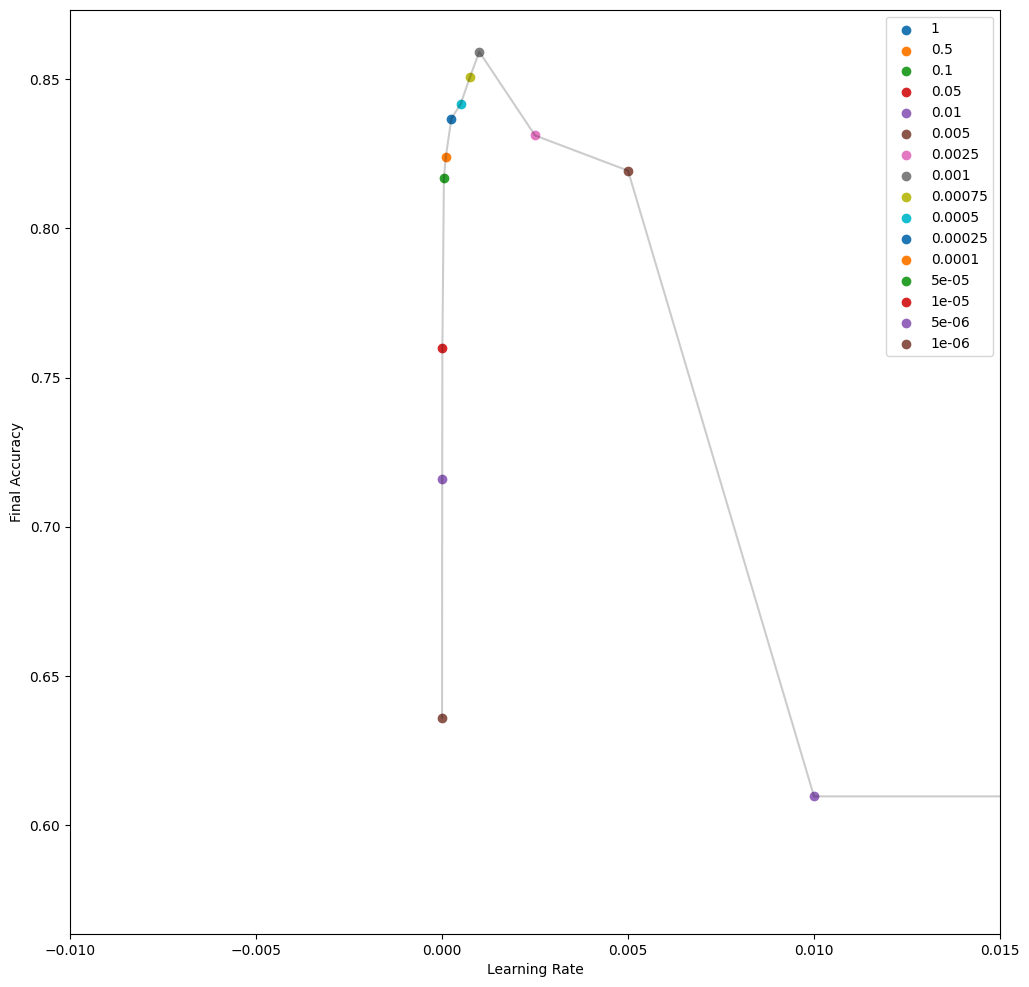

In [42]:
plt.figure(figsize=((12, 12)))

x = []
y = []

for lr, history in zip(lrs, histories):    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    plt.scatter(lr, acc[-1], label=lr)
    x.append(lr)
    y.append(acc[-1])

plt.plot(x, y, alpha=.2, color='black')
plt.ylabel("Final Accuracy")
plt.xlabel("Learning Rate")
plt.xlim((-0.01, 0.015))
plt.legend()


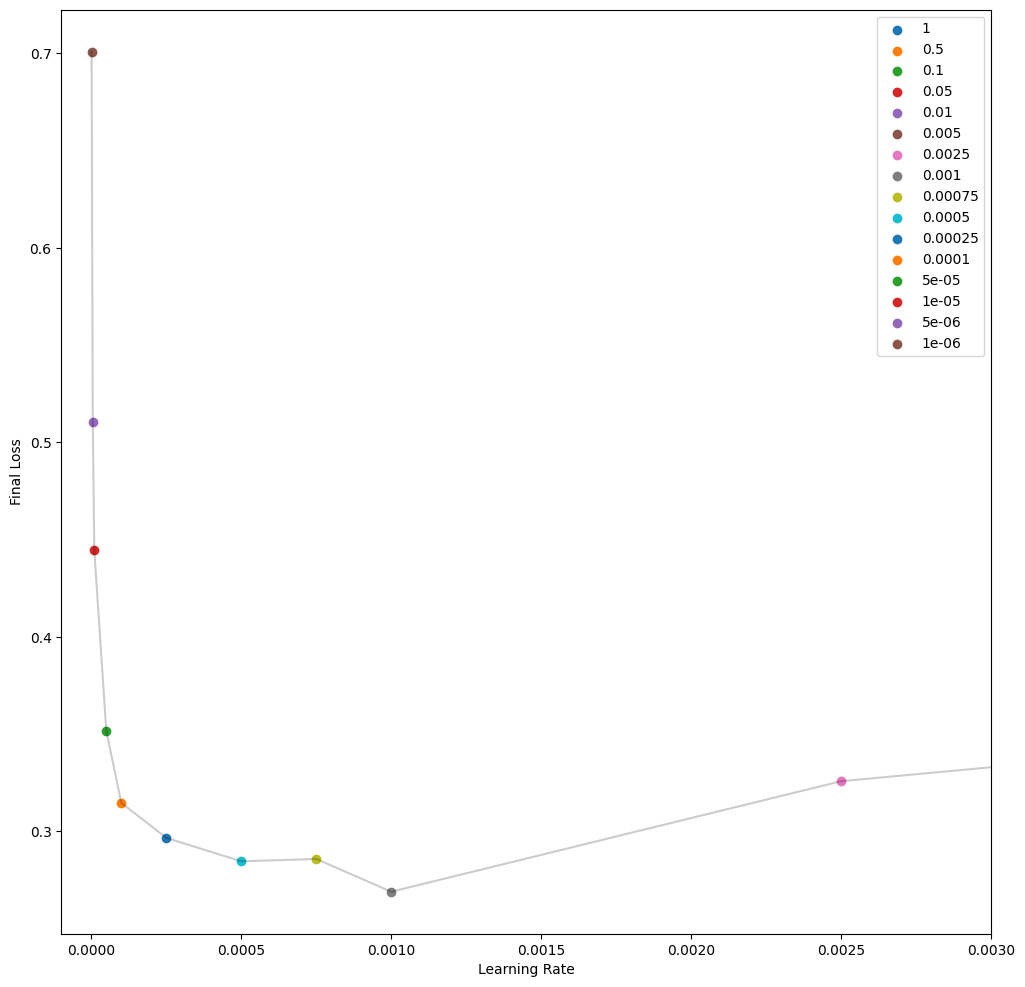

In [48]:
plt.figure(figsize=((12, 12)))

x = []
y = []

for lr, history in zip(lrs, histories):    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    plt.scatter(lr, loss[-1], label=lr)
    x.append(lr)
    y.append(loss[-1])

plt.plot(x, y, alpha=.2, color='black')
plt.ylabel("Final Loss")
plt.xlabel("Learning Rate")
plt.xlim((-0.0001, 0.003))
plt.legend()
